# Denoising AutoEncoder with conv

In [1]:
import tensorflow.keras as k
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import numpy as np
from data_util import *

## Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = load_mnist()

x_train: (60000, 28, 28)
y_train: (60000, 10)
x_test: (10000, 28, 28)
y_test: (10000, 10)


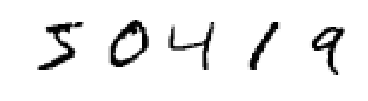

In [3]:
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
show_mnist(x_train[:5])

### Add Noise

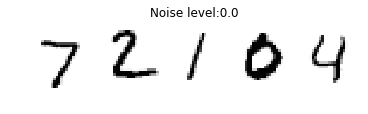

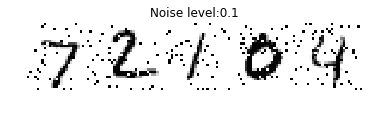

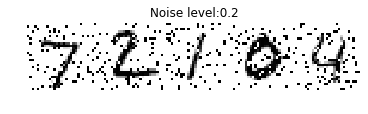

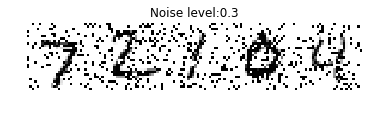

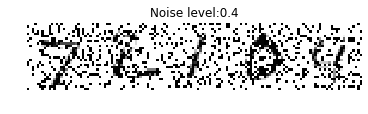

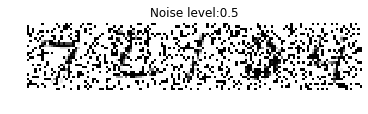

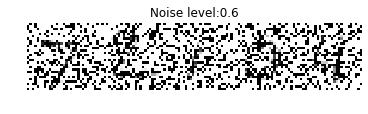

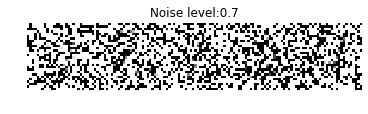

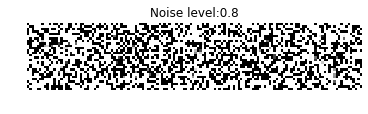

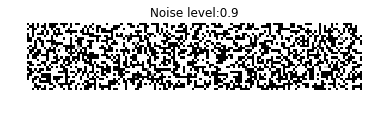

In [4]:
for level in range(10):
    noise_level = level / 10
    x_test_noise = sap_noise(x_test[:5], noise_level)
    show_mnist(x_test_noise, title = "Noise level:"+ str(noise_level))### Generate Noise data

### Generate Noise data

Generate Noise Dataset from noise_level=0.4 to noise_level=0.9

The result is going to be 5 * 60000 = 300,000 images

In [13]:
x_train_noisy = np.concatenate([sap_noise(x_train, level/10) for level in range(4,9)])

In [14]:
x_train_noisy.shape

(300000, 28, 28)

In [15]:
x_train_origin = np.concatenate([x_train for _ in range(5)])

In [16]:
x_train_origin.shape

(300000, 28, 28)

## Hyper parameters

In [5]:
input_shape = (28, 28)
hidden_unit = 64
batch_size = 128

## Model

### Encoder

In [6]:
encoder = k.models.Sequential(layers = [
    Reshape((28,28,1), input_shape=(28,28)),
    Conv2D(32, 3, strides=2, activation="relu", padding="same"),
    Conv2D(64, 3, strides=2, activation="relu", padding="same"),
    Conv2D(128, 3, strides=2, activation="relu"),
    Flatten(),
    Dense(hidden_unit, activation="relu"),
])

In [8]:
encoder = k.models.Sequential(layers = [
    Reshape((28,28,1), input_shape=(28,28)),
    Conv2D(32, 3, activation="relu"),
    Conv2D(32, 3, activation="relu"),
    Conv2D(32, 5, strides=2, padding='same', activation="relu"),
    Conv2D(64, 3, activation="relu"),
    Conv2D(64, 3, activation="relu"),
    Conv2D(64, 5, strides=2, padding='same', activation="relu"),
    Flatten(),
    Dense(128, activation="relu"),
#     Dense(hidden_unit, activation="relu"),
])

In [9]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          102464    
__________

### Decoder

In [14]:
decoder = k.models.Sequential(layers = [
    Dense(1152, input_shape=(32,)),
    Reshape((3,3,128)),
    Conv2DTranspose(64, 3, strides=2,activation="relu"),
    Conv2DTranspose(32, 3, strides=2,activation="relu", padding="same"),
    Conv2DTranspose(filters=1, strides=2, kernel_size=kernel_size, padding='same', activation="sigmoid"),
    Reshape(target_shape=(28,28)),
])

In [10]:
decoder = k.models.Sequential(layers = [
#     Dense(128, activation="relu", input_shape=(hidden_unit,)),
    Dense(1024, activation="relu", input_shape=(128,)),
    Reshape((4,4,64)),
    Conv2DTranspose(64, 5, strides=2, padding='same', activation="relu"),
    Conv2DTranspose(64, 3, activation="relu"),
    Conv2DTranspose(32, 3, activation="relu"),
    Conv2DTranspose(32, 5, strides=2, padding='same', activation="relu"),
    Conv2DTranspose(32, 3, activation="relu"),
    Conv2DTranspose(1, 3, activation="relu"),
    Reshape((28,28)),
])

In [11]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              132096    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 64)          102464    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 12, 12, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 24, 24, 32)        25632     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 26, 26, 32)        9248      
__________

### AutoEncoder = Encoder + Decoder

In [12]:
x_input = Input(shape=input_shape,)
autoencoder = Model(x_input, decoder(encoder(x_input)), name = "autoencoder")
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 128)               324288    
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28)            325121    
Total params: 649,409
Trainable params: 649,409
Non-trainable params: 0
_________________________________________________________________


### Compile and Train

In [17]:
autoencoder.compile(loss='mse', optimizer='adam')

In [28]:
autoencoder.fit(x_train_noisy, x_train_origin, batch_size=batch_size,epochs=10, shuffle=True)

Epoch 1/10
300000/300000 [==============================] - 66s 220us/step - loss: 0.0085
Epoch 2/10
300000/300000 [==============================] - 66s 221us/step - loss: 0.0087
Epoch 3/10
300000/300000 [==============================] - 66s 221us/step - loss: 0.0085
Epoch 4/10
300000/300000 [==============================] - 66s 219us/step - loss: 0.0082
Epoch 5/10
300000/300000 [==============================] - 66s 219us/step - loss: 0.0081
Epoch 6/10
300000/300000 [==============================] - 65s 217us/step - loss: 0.0081
Epoch 7/10
300000/300000 [==============================] - 66s 220us/step - loss: 0.0080
Epoch 8/10
300000/300000 [==============================] - 65s 218us/step - loss: 0.0079
Epoch 9/10
300000/300000 [==============================] - 65s 218us/step - loss: 0.0077
Epoch 10/10
300000/300000 [==============================] - 67s 223us/step - loss: 0.0075


### Save Model

In [30]:
autoencoder.save('models/dae_conv_noise9.h5')
encoder.save('models/dae_conv_encoder_noise9.h5')
decoder.save('models/dae_conv_decoder_noise9.h5')

In [36]:
model = k.models.load_model('models/dae.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_input (InputLayer)    (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 128)               100480    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
60000/60000 [==============================] - 2s 25us/step - loss: 0.0067


In [44]:
model.fit(x_train_noisy, x_train, batch_size = batch_size, epochs=1)

Epoch 1/1
60000/60000 [==============================] - 1s 23us/step - loss: 0.0064


### Reconstruct

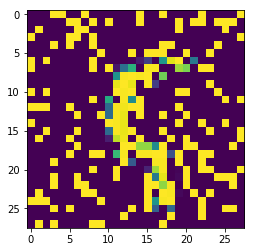

In [19]:
plt.imshow(x_train_noisy[100])

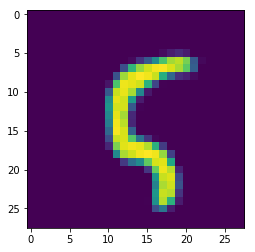

In [20]:
decoded = autoencoder.predict(x_train_noisy[100].reshape(1,28,28))
decoded = decoded.reshape(28,28)
plt.imshow(decoded)

In [24]:
autoencoder.evaluate(x_test, x_test)

10000/10000 [==============================] - 1s 64us/step


0.007611034303903579

## Reconstruct in Different Noise Level

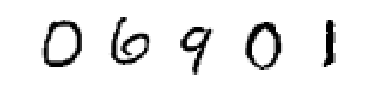

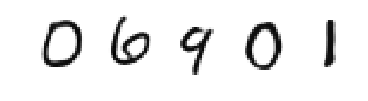

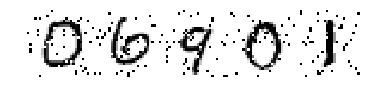

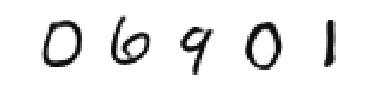

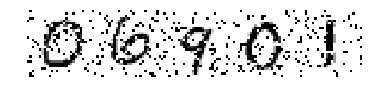

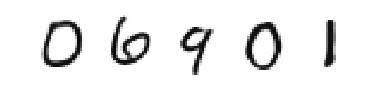

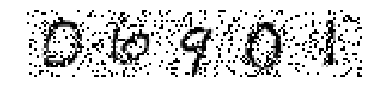

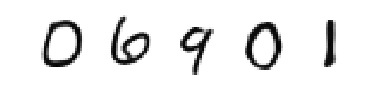

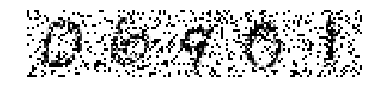

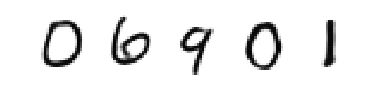

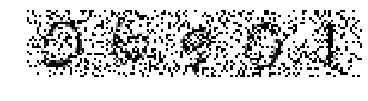

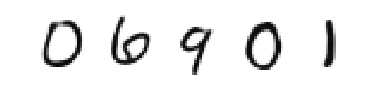

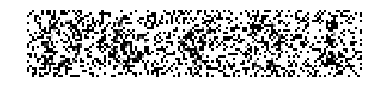

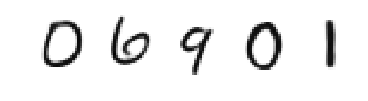

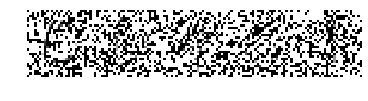

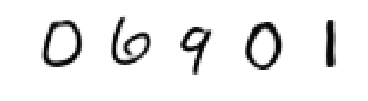

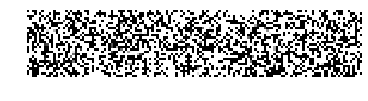

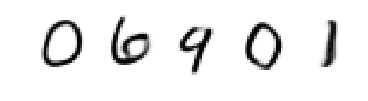

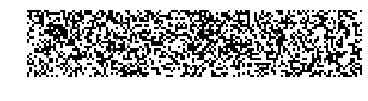

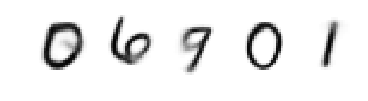

In [29]:
for i in range(10):
    noise_level = i / 10
    noisedata = sap_noise(x_test[10:15], noise_level)
    decoded = autoencoder.predict(noisedata)
    show_mnist(noisedata)
    show_mnist(decoded)